In [91]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
sns.set_theme()
register_matplotlib_converters()

In [92]:
df = pd.read_csv("historical-daily-weather\Prepped data.csv", index_col="date")
df.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-24,0.0,26.80,31.4,24.4,11.7,38.2,7.0
2009-01-25,0.8,25.90,27.8,24.4,12.7,38.2,3.4
2009-01-26,0.0,25.90,29.6,23.7,12.4,42.5,5.9
2009-01-27,0.0,26.25,30.2,23.7,10.4,38.9,6.5
2009-01-28,0.0,26.60,31.9,23.7,10.3,32.4,8.2


In [93]:
df.index = pd.to_datetime(df.index, infer_datetime_format=True)
df.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-24,0.0,26.80,31.4,24.4,11.7,38.2,7.0
2009-01-25,0.8,25.90,27.8,24.4,12.7,38.2,3.4
2009-01-26,0.0,25.90,29.6,23.7,12.4,42.5,5.9
2009-01-27,0.0,26.25,30.2,23.7,10.4,38.9,6.5
2009-01-28,0.0,26.60,31.9,23.7,10.3,32.4,8.2


In [94]:
plt.rc("figure",figsize=(16, 12))
plt.rc("font",size=13)

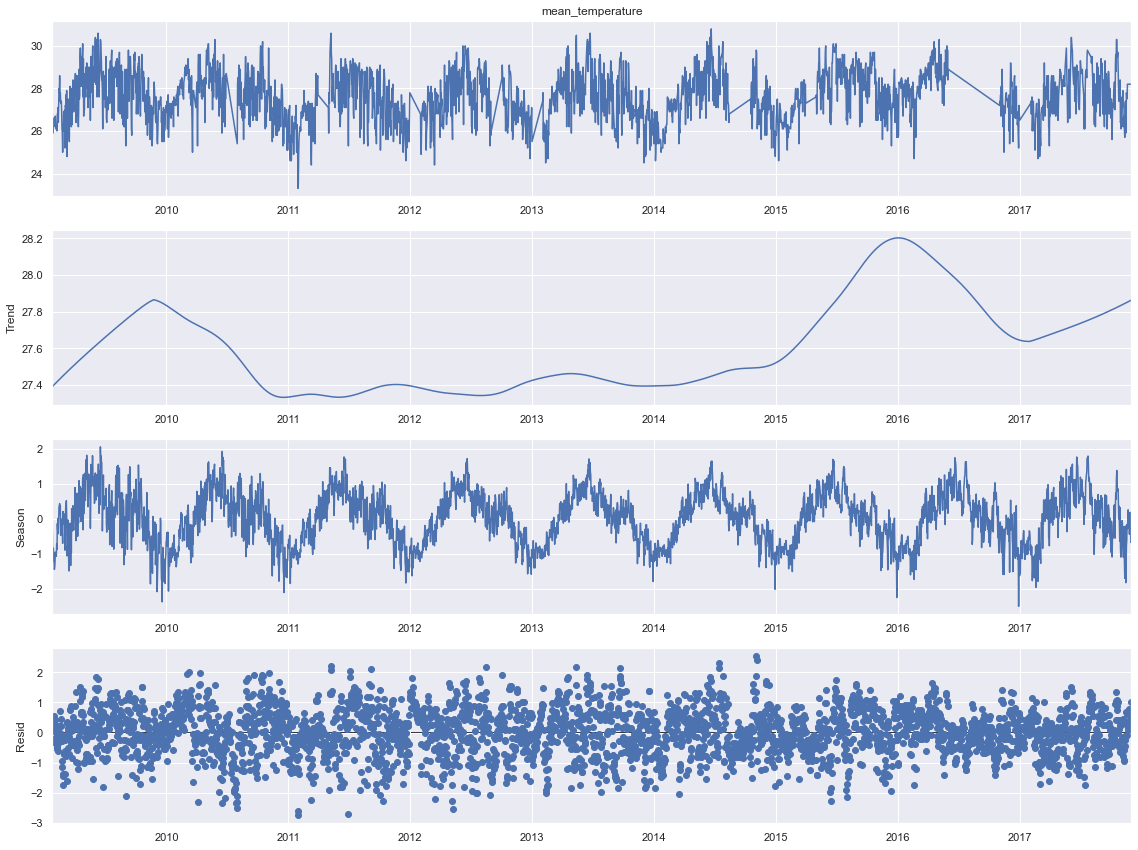

In [95]:
from statsmodels.tsa.seasonal import STL
stl = STL(df["mean_temperature"],period=365,seasonal=15)
res = stl.fit()
fig = res.plot()

In [96]:
#Monthly aggregate
df_m = df.resample('MS').mean()
df_m.head()

,daily_rainfall_total,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,temperature_range
date,,,,,,,
2009-01-01,0.100000,26.331250,30.212500,24.100000,11.225000,37.100000,6.112500
2009-02-01,5.285714,26.767857,31.442857,24.260714,9.564286,35.842857,7.182143
2009-03-01,11.435484,26.938710,32.117742,24.000000,7.112903,35.674194,8.117742
2009-04-01,4.960000,28.120000,32.196667,25.066667,7.363333,35.086667,7.130000
2009-05-01,6.632258,28.483871,32.590323,25.093548,7.451613,36.103226,7.496774


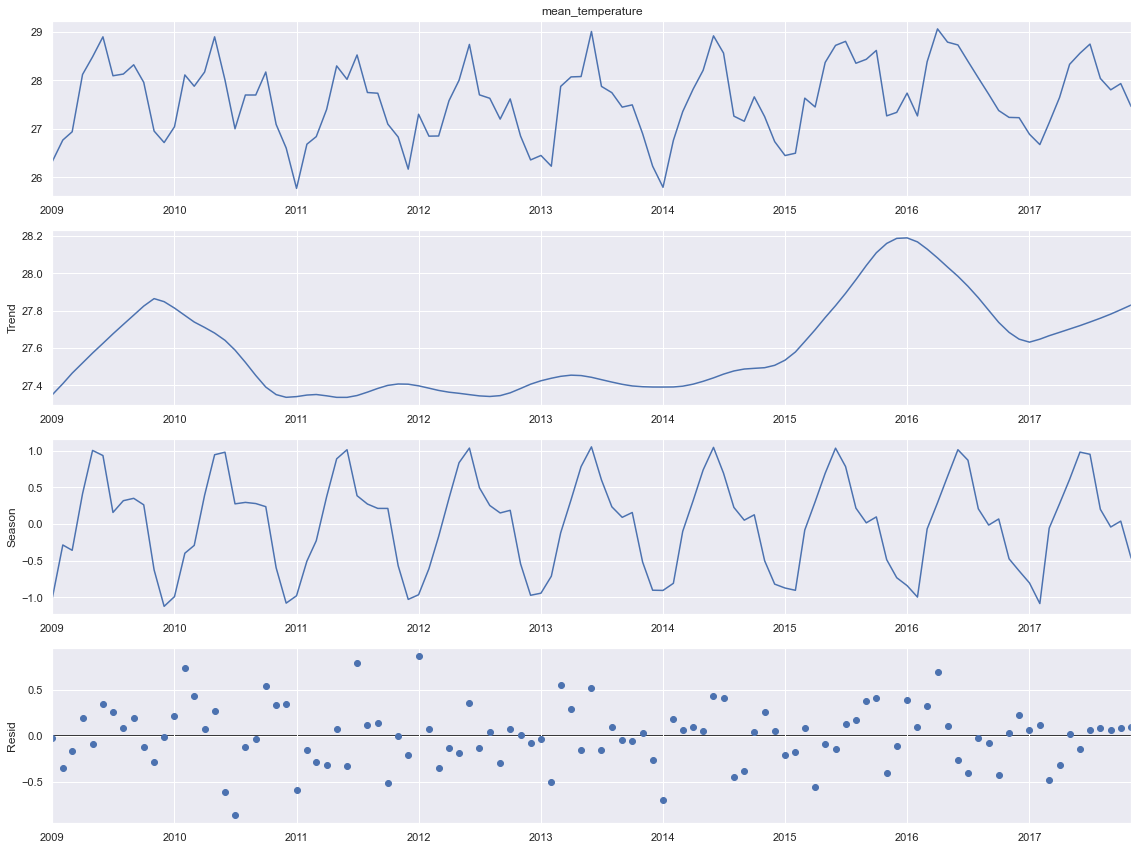

In [97]:
stl = STL(df_m["mean_temperature"],period=12,seasonal=15)
res = stl.fit()
fig = res.plot()

General increasing trend in mean temperatures with spikes from 2009 to 2010 and 2015 to 2016. Looking at the seasonsality, mean temperatures peak in May and June and are lowest in January and February.

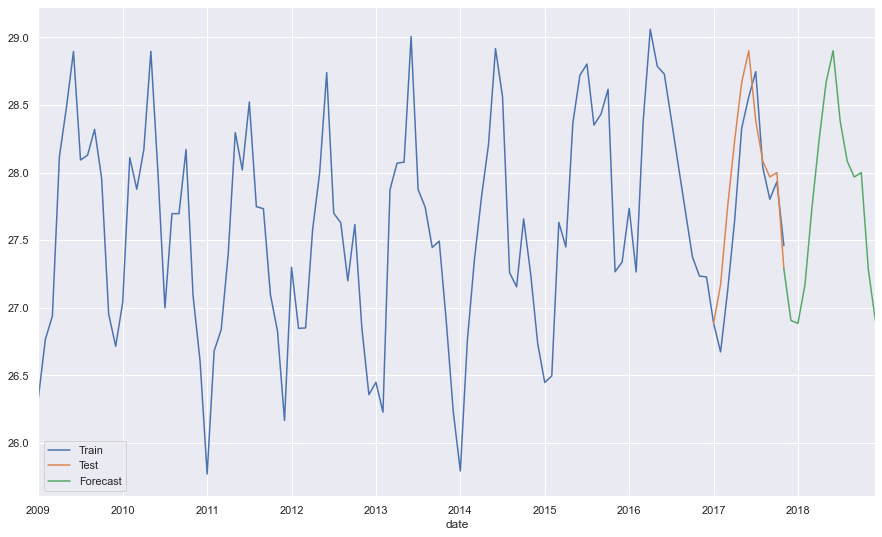

mean absolute error: 0.2917644382086234


<Figure size 1152x864 with 0 Axes>

In [109]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing   
train = df_m.loc[:'2016-12-01']
test = df_m.loc['2017-01-01':]

# train model and predict
hwmodel = ExponentialSmoothing(train["mean_temperature"], seasonal='mul', seasonal_periods=12).fit()
pred_test = hwmodel.predict(start='2017-01-01', end='2017-11-01')
pred_forecast = hwmodel.predict(start='2017-11-01', end='2018-12-01')

# plot data and prediction
df_m["mean_temperature"].plot(figsize=(15,9), label='Train')
pred_test.plot(label='Test')
pred_forecast.plot(label='Forecast')
plt.legend()
plt.show()
plt.savefig('figure.png')

import sklearn
from sklearn.metrics import mean_absolute_error

print(f"mean absolute error: {mean_absolute_error(test['mean_temperature'],pred_test)}")